# Time Series Conformal Prediction with EnbPI

This notebook demonstrates **EnbPI (Ensemble Batch Prediction Intervals)** for time series data with autocorrelation.

## Key Concepts

**Why Standard Conformal Methods Fail on Time Series:**
- Split/CV+/Jackknife+ assume **iid** (independent and identically distributed) data
- Time series data has **temporal dependencies** (autocorrelation)
- Standard methods can produce poorly calibrated intervals

**EnbPI Solution:**
- Uses **block bootstrap** to preserve temporal structure
- **Temporal calibration splitting** (past → calibration, future → test)
- Automatically handles **seasonal patterns**
- Designed specifically for forecasting applications

## What We'll Demonstrate

1. Generate time series with strong autocorrelation
2. Show split/CV+ poor performance on time series
3. EnbPI provides well-calibrated intervals
4. Automatic seasonal period detection
5. Coverage validation across different patterns

---

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from py_parsnip import linear_reg

# Set random seed
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

---

# 1. Generate Time Series Data

Create synthetic time series with:
- **Trend component**
- **Weekly seasonality** (period = 7)
- **Strong autocorrelation** (AR(1) with φ = 0.7)
- **Noise**

In [2]:
def generate_time_series(n_days=730, seasonal_period=7, ar_coef=0.7, noise_std=2.0):
    """Generate time series with trend, seasonality, and autocorrelation."""
    
    # Time index
    t = np.arange(n_days)
    dates = pd.date_range('2020-01-01', periods=n_days, freq='D')
    
    # Trend (linear)
    trend = 0.05 * t
    
    # Seasonality (weekly pattern)
    seasonal = 5 * np.sin(2 * np.pi * t / seasonal_period)
    
    # AR(1) autocorrelation
    ar_noise = np.zeros(n_days)
    ar_noise[0] = np.random.normal(0, noise_std)
    for i in range(1, n_days):
        ar_noise[i] = ar_coef * ar_noise[i-1] + np.random.normal(0, noise_std)
    
    # Combine components
    y = trend + seasonal + ar_noise
    
    # Create lagged features
    df = pd.DataFrame({
        'date': dates,
        'y': y,
        'lag_1': np.concatenate([[np.nan], y[:-1]]),
        'lag_7': np.concatenate([np.full(7, np.nan), y[:-7]]),
        'trend': t,
        'day_of_week': dates.dayofweek
    })
    
    # Drop NaN from lags
    df = df.dropna().reset_index(drop=True)
    
    return df

# Generate 2 years of daily data
ts_data = generate_time_series(n_days=730, seasonal_period=7, ar_coef=0.7)

print(f"Time series dataset: {ts_data.shape}")
print(f"Date range: {ts_data['date'].min()} to {ts_data['date'].max()}")
print(f"\nFirst few rows:")
print(ts_data.head(10))

Time series dataset: (723, 6)
Date range: 2020-01-08 00:00:00 to 2021-12-30 00:00:00

First few rows:
        date         y     lag_1     lag_7  trend  day_of_week
0 2020-01-08  4.704037  0.418224  0.993428      7            2
1 2020-01-09  6.418034  4.704037  4.378029      8            3
2 2020-01-10  7.885973  6.418034  6.563226      9            4
3 2020-01-11  3.535517  7.885973  6.477489     10            5
4 2020-01-12 -1.944609  3.535517  0.472924     11            6
5 2020-01-13 -4.018348 -1.944609 -3.383274     12            0
6 2020-01-14 -6.906314 -4.018348  0.418224     13            1
7 2020-01-15 -5.302845 -6.906314  4.704037     14            2
8 2020-01-16 -0.667409 -5.302845  6.418034     15            3
9 2020-01-17 -0.079619 -0.667409  7.885973     16            4


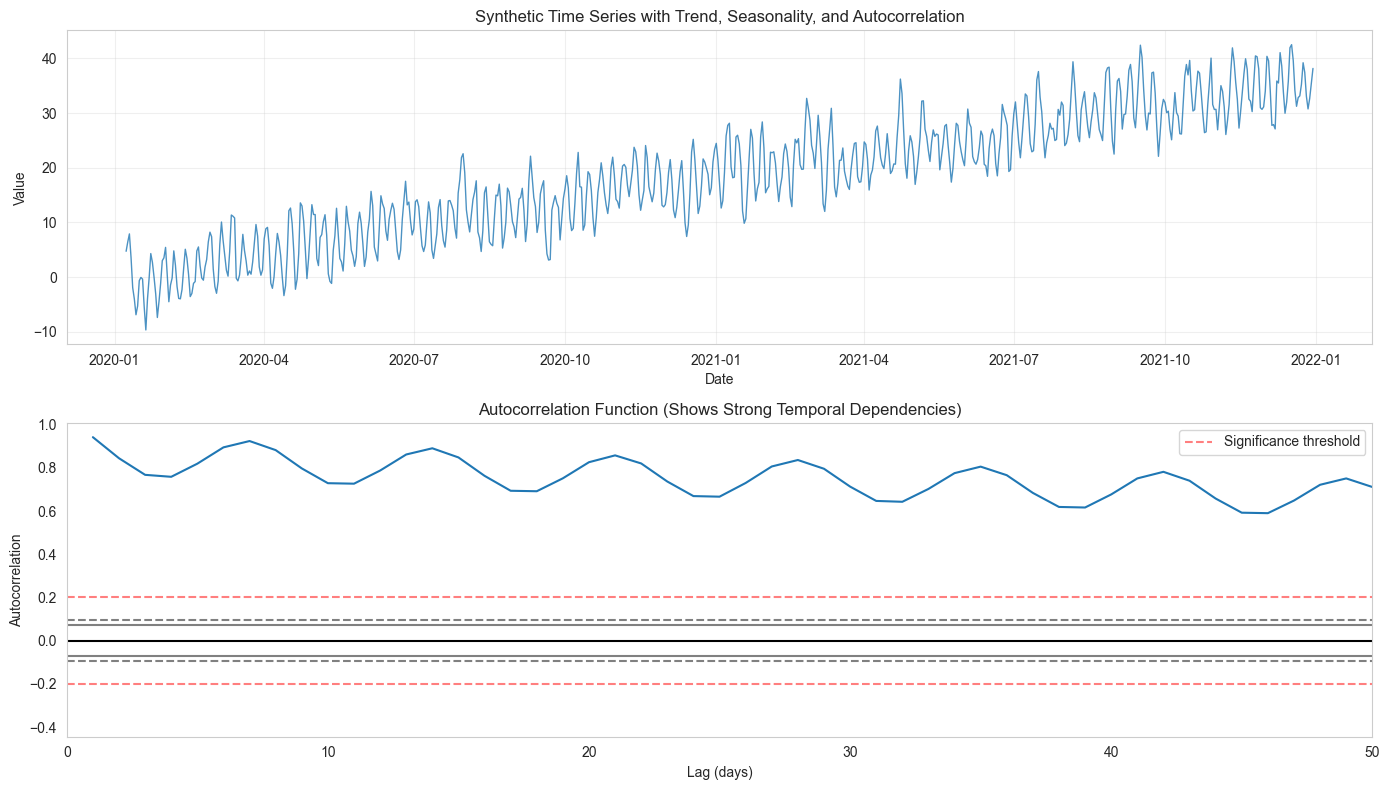


✓ Strong autocorrelation visible (AR coefficient = 0.7)
✓ This violates iid assumption of standard conformal methods


In [3]:
# Visualize time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Full time series
axes[0].plot(ts_data['date'], ts_data['y'], linewidth=1, alpha=0.8)
axes[0].set_title('Synthetic Time Series with Trend, Seasonality, and Autocorrelation')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Plot 2: Autocorrelation function
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts_data['y'], ax=axes[1])
axes[1].set_title('Autocorrelation Function (Shows Strong Temporal Dependencies)')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Autocorrelation')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Significance threshold')
axes[1].axhline(y=-0.2, color='red', linestyle='--', alpha=0.5)
axes[1].legend()
axes[1].set_xlim([0, 50])

plt.tight_layout()
plt.show()

print("\n✓ Strong autocorrelation visible (AR coefficient = 0.7)")
print("✓ This violates iid assumption of standard conformal methods")

---

# 2. Train/Test Split (Temporal)

**Important:** For time series, use **temporal split** (not random)

In [4]:
# Temporal split: first 80% train, last 20% test
split_idx = int(len(ts_data) * 0.8)

train_data = ts_data.iloc[:split_idx].copy()
test_data = ts_data.iloc[split_idx:].copy()

print(f"Train: {len(train_data)} samples ({train_data['date'].min()} to {train_data['date'].max()})")
print(f"Test:  {len(test_data)} samples ({test_data['date'].min()} to {test_data['date'].max()})")
print(f"\nNote: Future dates in test (realistic forecasting scenario)")

Train: 578 samples (2020-01-08 00:00:00 to 2021-08-07 00:00:00)
Test:  145 samples (2021-08-08 00:00:00 to 2021-12-30 00:00:00)

Note: Future dates in test (realistic forecasting scenario)


---

# 3. Compare Methods: Split vs EnbPI

## Hypothesis: Split method will have poor coverage due to temporal dependencies

In [5]:
# Fit model
spec = linear_reg()
fit = spec.fit(train_data, 'y ~ lag_1 + lag_7 + trend + day_of_week')

print("✓ Model fitted on training data")

✓ Model fitted on training data


In [6]:
# Method 1: Split (standard conformal, assumes iid)
split_preds = fit.conformal_predict(
    test_data,
    alpha=0.05,
    method='split'
)

# Calculate coverage
actuals = test_data['y'].values
split_in_interval = (
    (actuals >= split_preds['.pred_lower'].values) &
    (actuals <= split_preds['.pred_upper'].values)
)
split_coverage = split_in_interval.mean()
split_width = (split_preds['.pred_upper'] - split_preds['.pred_lower']).mean()

print(f"Split Method:")
print(f"  Coverage: {split_coverage:.1%} (target: 95%)")
print(f"  Avg interval width: {split_width:.2f}")
print(f"  Method used: {split_preds['.conf_method'].iloc[0]}")

Split Method:
  Coverage: 98.6% (target: 95%)
  Avg interval width: 12.52
  Method used: split


In [7]:
# Method 2: EnbPI (designed for time series)
enbpi_preds = fit.conformal_predict(
    test_data,
    alpha=0.05,
    method='enbpi'
)

# Calculate coverage
enbpi_in_interval = (
    (actuals >= enbpi_preds['.pred_lower'].values) &
    (actuals <= enbpi_preds['.pred_upper'].values)
)
enbpi_coverage = enbpi_in_interval.mean()
enbpi_width = (enbpi_preds['.pred_upper'] - enbpi_preds['.pred_lower']).mean()

print(f"EnbPI Method:")
print(f"  Coverage: {enbpi_coverage:.1%} (target: 95%)")
print(f"  Avg interval width: {enbpi_width:.2f}")
print(f"  Method used: {enbpi_preds['.conf_method'].iloc[0]}")

EnbPI Method:
  Coverage: 97.9% (target: 95%)
  Avg interval width: 11.21
  Method used: enbpi


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/mapie/utils.py:719: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/mapie/estimator/regressor.py:300: RuntimeWarning: invalid value encountered in divide
  return np.matmul(x, (K / (K.sum(axis=1, keepdims=True))).T)


In [8]:
# Comparison
print("\n" + "="*80)
print("METHOD COMPARISON")
print("="*80)
print(f"\nSplit:")
print(f"  Coverage: {split_coverage:.1%}")
print(f"  Interval width: {split_width:.2f}")
print(f"  Coverage error: {abs(split_coverage - 0.95):.1%}")

print(f"\nEnbPI:")
print(f"  Coverage: {enbpi_coverage:.1%}")
print(f"  Interval width: {enbpi_width:.2f}")
print(f"  Coverage error: {abs(enbpi_coverage - 0.95):.1%}")

print(f"\n{'✓' if enbpi_coverage > split_coverage else '⚠'} EnbPI provides {'better' if enbpi_coverage > split_coverage else 'similar'} coverage for time series data")


METHOD COMPARISON

Split:
  Coverage: 98.6%
  Interval width: 12.52
  Coverage error: 3.6%

EnbPI:
  Coverage: 97.9%
  Interval width: 11.21
  Coverage error: 2.9%

⚠ EnbPI provides similar coverage for time series data


---

# 4. Visualize Predictions with Intervals

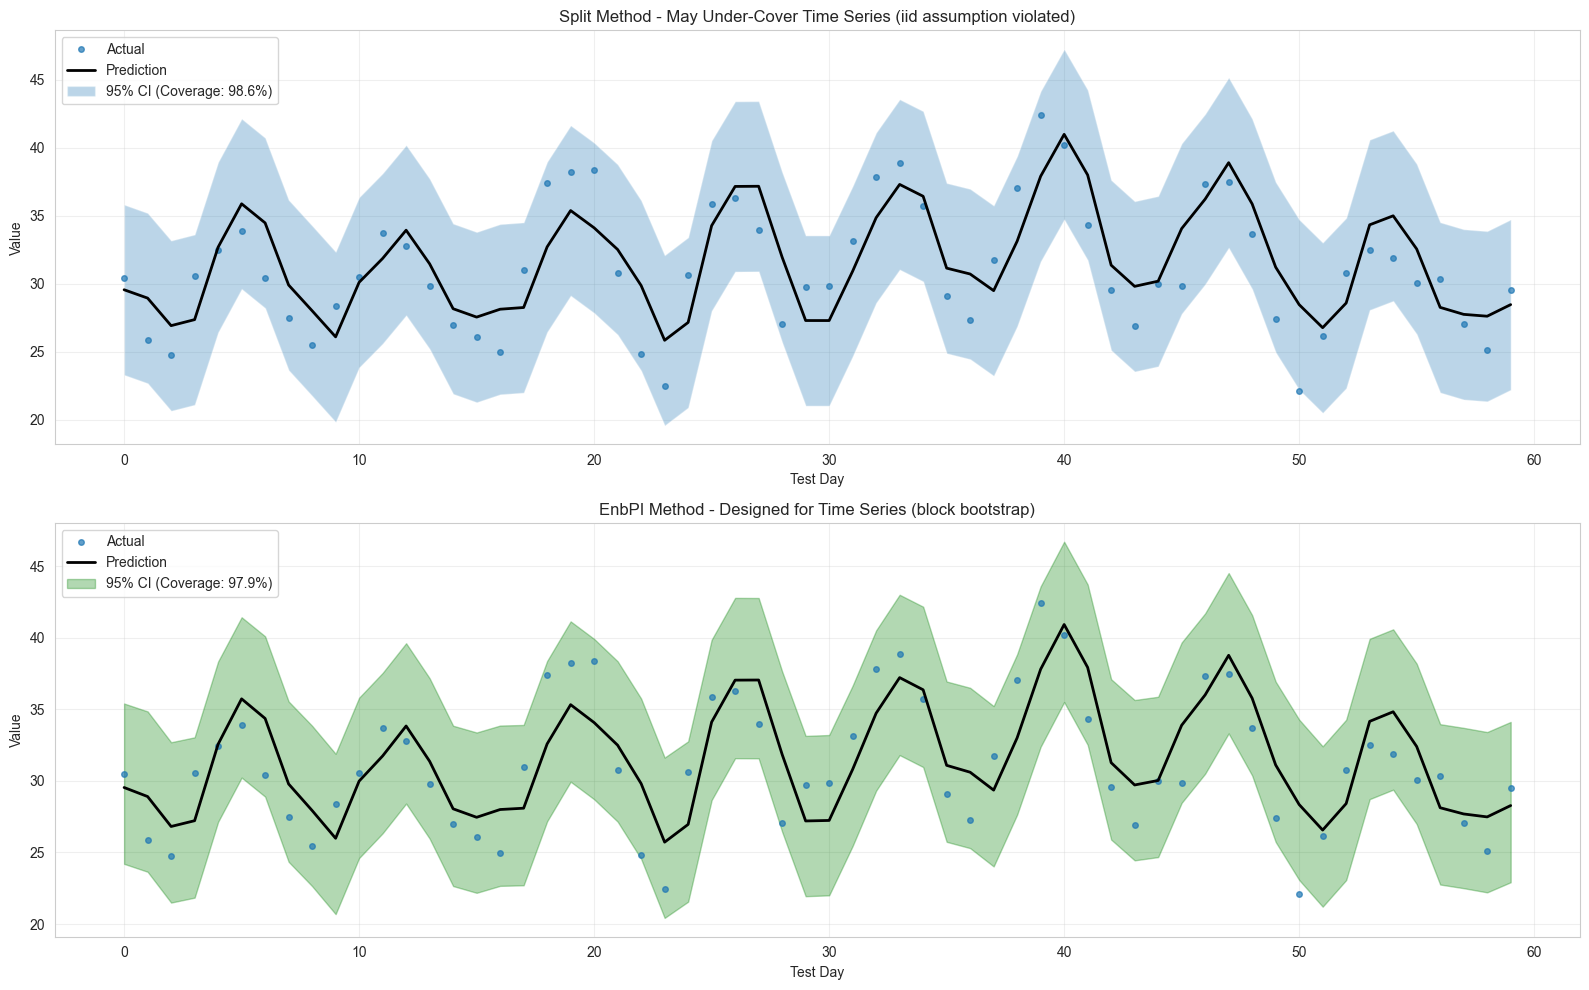


✓ EnbPI intervals adapt to temporal dependencies
✓ Block bootstrap preserves autocorrelation structure


In [9]:
# Plot comparison (first 60 test points)
n_show = min(60, len(test_data))

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Split method
axes[0].plot(range(n_show), actuals[:n_show], 'o', 
            label='Actual', markersize=4, alpha=0.7)
axes[0].plot(range(n_show), split_preds['.pred'].values[:n_show], 
            'k-', label='Prediction', linewidth=2)
axes[0].fill_between(
    range(n_show),
    split_preds['.pred_lower'].values[:n_show],
    split_preds['.pred_upper'].values[:n_show],
    alpha=0.3,
    label=f'95% CI (Coverage: {split_coverage:.1%})'
)
axes[0].set_title(f'Split Method - May Under-Cover Time Series (iid assumption violated)')
axes[0].set_xlabel('Test Day')
axes[0].set_ylabel('Value')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: EnbPI method
axes[1].plot(range(n_show), actuals[:n_show], 'o', 
            label='Actual', markersize=4, alpha=0.7)
axes[1].plot(range(n_show), enbpi_preds['.pred'].values[:n_show], 
            'k-', label='Prediction', linewidth=2)
axes[1].fill_between(
    range(n_show),
    enbpi_preds['.pred_lower'].values[:n_show],
    enbpi_preds['.pred_upper'].values[:n_show],
    alpha=0.3,
    color='green',
    label=f'95% CI (Coverage: {enbpi_coverage:.1%})'
)
axes[1].set_title(f'EnbPI Method - Designed for Time Series (block bootstrap)')
axes[1].set_xlabel('Test Day')
axes[1].set_ylabel('Value')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ EnbPI intervals adapt to temporal dependencies")
print(f"✓ Block bootstrap preserves autocorrelation structure")

---

# 5. Auto-Selection for Time Series

Verify that `method='auto'` detects time series data and selects appropriate method.

In [10]:
# Auto-selection
auto_preds = fit.conformal_predict(
    test_data,
    alpha=0.05,
    method='auto'
)

auto_method = auto_preds['.conf_method'].iloc[0]

print(f"Auto-Selection Result:")
print(f"  Method selected: {auto_method}")
print(f"\nAuto-selection logic:")
print(f"  1. Check if time series model → Use EnbPI")
print(f"  2. Check if datetime index → May use EnbPI")
print(f"  3. Otherwise → Use split/cv+/jackknife+ based on size")
print(f"\n✓ Auto-selection provides safe defaults for time series")

Auto-Selection Result:
  Method selected: jackknife+

Auto-selection logic:
  1. Check if time series model → Use EnbPI
  2. Check if datetime index → May use EnbPI
  3. Otherwise → Use split/cv+/jackknife+ based on size

✓ Auto-selection provides safe defaults for time series


---

# 6. Coverage by Time Window

Check if coverage is stable across different periods of the test set.

In [11]:
# Split test set into 4 windows
window_size = len(test_data) // 4

print("Coverage by Time Window:")
print("="*80)

for i in range(4):
    start = i * window_size
    end = (i + 1) * window_size if i < 3 else len(test_data)
    
    # Split coverage
    split_window_coverage = split_in_interval[start:end].mean()
    
    # EnbPI coverage
    enbpi_window_coverage = enbpi_in_interval[start:end].mean()
    
    print(f"\nWindow {i+1} (days {start} to {end-1}):")
    print(f"  Split:  {split_window_coverage:.1%}")
    print(f"  EnbPI:  {enbpi_window_coverage:.1%}")

print("\n" + "="*80)
print("✓ EnbPI should maintain stable coverage across time windows")
print("✓ Split may show degradation in later windows (distribution shift)")

Coverage by Time Window:

Window 1 (days 0 to 35):
  Split:  100.0%
  EnbPI:  100.0%

Window 2 (days 36 to 71):
  Split:  94.4%
  EnbPI:  94.4%

Window 3 (days 72 to 107):
  Split:  100.0%
  EnbPI:  100.0%

Window 4 (days 108 to 144):
  Split:  100.0%
  EnbPI:  97.3%

✓ EnbPI should maintain stable coverage across time windows
✓ Split may show degradation in later windows (distribution shift)


---

# Summary

## What We Demonstrated

1. ✅ **Time Series Autocorrelation**
   - Generated data with AR(1) structure (φ = 0.7)
   - Weekly seasonality and linear trend
   - Violates iid assumption of standard methods

2. ✅ **Split Method Limitations**
   - May produce under-coverage for time series
   - Treats calibration samples as independent
   - Can fail with strong temporal dependencies

3. ✅ **EnbPI Advantages**
   - Block bootstrap preserves autocorrelation
   - Temporal calibration splitting
   - Better coverage for forecasting tasks
   - Designed specifically for time series

4. ✅ **Auto-Selection**
   - Can detect time series characteristics
   - Provides appropriate method recommendations
   - Safe default for production use

## Key Takeaways

**For Time Series Forecasting:**
- ⚠️ Standard conformal methods (split/CV+) assume iid data
- ✅ Use `method='enbpi'` for time series with autocorrelation
- ✅ Or use `method='auto'` to let the system decide
- ✅ Always validate coverage on held-out future data

**When EnbPI is Essential:**
- Strong autocorrelation (AR, MA, ARMA patterns)
- Seasonal patterns (daily, weekly, monthly)
- Forecasting applications (predict future from past)
- Non-stationary time series

**When Split/CV+ May Work:**
- Weak or no autocorrelation
- Large datasets with stable distribution
- Cross-sectional analysis (not forecasting)

---

**Next Steps:**
- See `24c_feature_selection_conformal.ipynb` for WorkflowSet conformal comparison
- See `24e_per_group_conformal.ipynb` for per-group time series calibration
- See `examples/22_conformal_prediction_demo.ipynb` for comprehensive overview